In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import time
import torch
import cv2
import playsound
from model.detr import DETR
from model.glpdepth import GLP
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

############################# Start ###########################
warnings.filterwarnings(action='ignore')

In [2]:
##############################################################################################################################################
# 모델 정의
# DETR 불러오기
model_path = 'facebookresearch/detr:main'
model_backbone = 'detr_resnet101'
#sys.modules.pop('models') # ModuleNotFoundError: No module named 'models.backbone' 이 에러 발생시 수행
DETR = DETR(model_path, model_backbone)
DETR.model.eval()
DETR.model.to(device)

# GLPdepth 불러오기
glp_pretrained = 'vinvino02/glpn-kitti'
GLPdepth = GLP(glp_pretrained)
GLPdepth.model.eval()
GLPdepth.model.to(device)

# Z-estimator 불러오기
'''
사용한 변수
: xmin, ymin, xmax, ymax, depth_mean, depth_median, depth_max, depth_mean_trim, width, height, Misc, bicycle, car, person, train, truck

'''
z_model = pickle.load(open('./model/xgb_model.model', 'rb'))

#스케일러 불러오기
scaler = pickle.load(open('./model/standard_scaler.pkl', 'rb'))

Using cache found in C:\Users\Admin/.cache\torch\hub\facebookresearch_detr_main


[01:08:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[01:08:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[01:08:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.sav

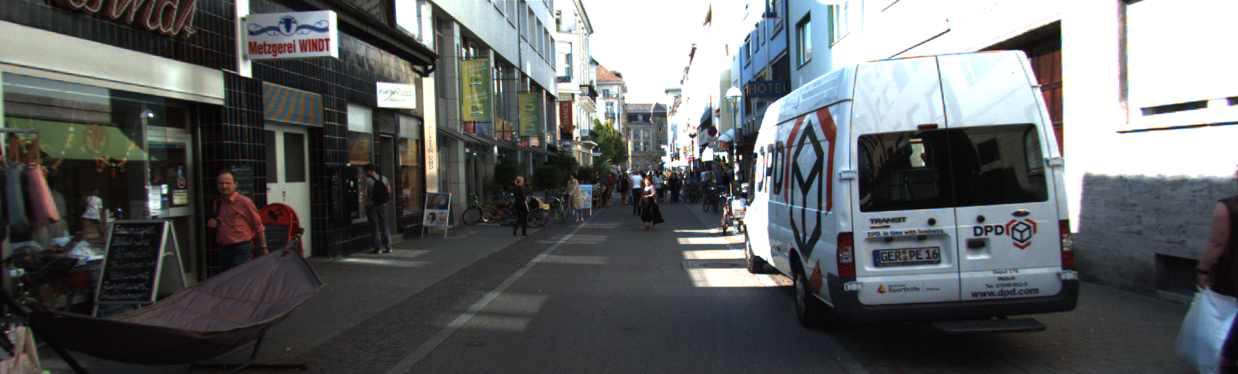

In [3]:
img = Image.open("./datasets/data/image/train/004532.png")
img_shape = cv2.imread("./datasets/data/image/train/004532.png").shape
img

In [4]:
scores, boxes = DETR.detect(img)
prediction = GLPdepth.predict(img, img_shape)

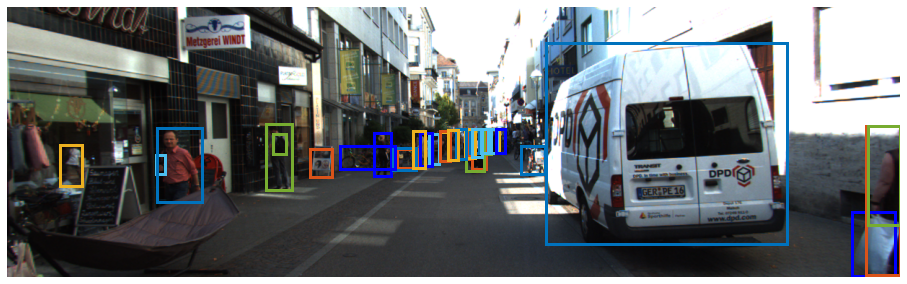

In [5]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0,0,1], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# 시각화 (특정 부분만)
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        #text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        #ax.text(xmin, ymin, text, fontsize=15,
        #        bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(img, scores, boxes)

In [14]:
len(boxes) # 33

33

In [6]:
img_shape

(374, 1238, 3)

In [7]:
prediction = GLPdepth.predict(img, img_shape)
prediction.shape

(374, 1238)

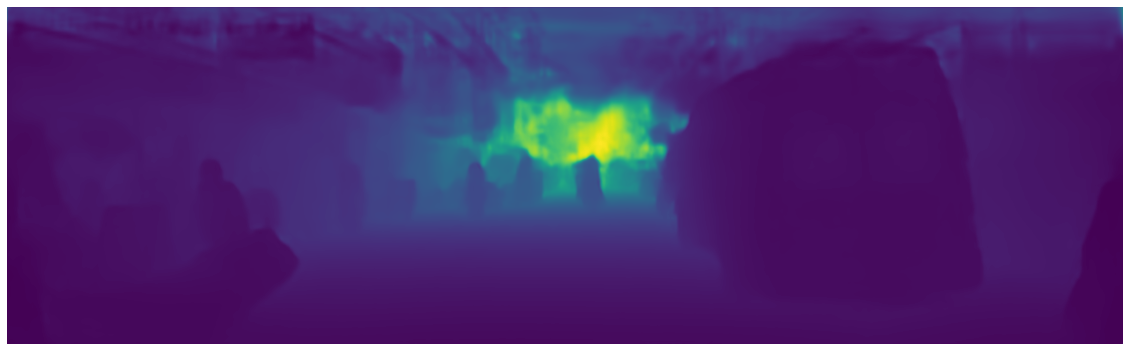

In [8]:
plt.figure(figsize=(20,20))
k=1
for i in range(1,3):    
    if i % 2 == 0:
        plt.imshow(prediction)
        k += 1
    plt.axis('off')

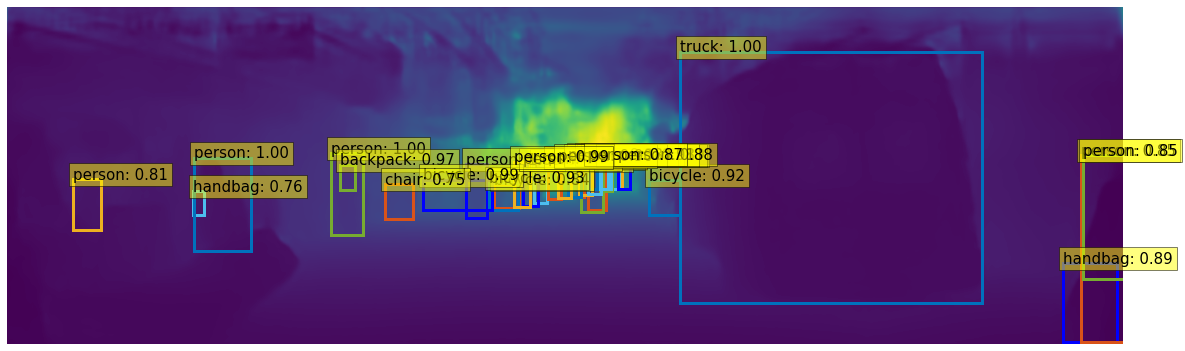

In [9]:
#img2 = Image.open("./datasets/GLPdepth.png")
#img2_shape = cv2.imread("./datasets/GLPdepth.png").shape

# 시각화 (특정 부분만)
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(20,20))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(prediction, scores, boxes)
#print(img2_shape)

In [10]:
data = pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8,9])
# BBOX input
for p, (xmin, ymin, xmax, ymax) in zip(scores, boxes.tolist()):
    '''
    xmin, xmax 해서 본인 차선 range 안에 있는 object만 거리판단하기.
    '''
    prt = True

    # class extraction
    cl = p.argmax()

    # class 설정
    classes = DETR.CLASSES[cl]
    if classes == 'motorcycle':
        classes = 'bicycle'

    elif classes == 'bus':
        classes = 'train'

    elif classes not in ['person', 'truck', 'car', 'bicycle', 'train']:
        classes = 'Misc'

    # color 맞추기
    if classes in ['Misc','person', 'truck', 'car', 'bicycle', 'train']:
        cl = ['Misc','person', 'truck', 'car', 'bicycle', 'train'].index(classes)
    else:
        continue

    # Detection rgb
    r,g,b = DETR.COLORS[cl][0] * 255, DETR.COLORS[cl][1] * 255, DETR.COLORS[cl][2] * 255
    rgb = (r,g,b)

    # Predict value1
    x1 = xmin
    y1 = ymin
    x2 = xmax
    y2 = ymax
    height = ymax - ymin
    width = xmax - xmin

    if int(xmin) < 0:
        xmin = 0
    if int(ymin) < 0:
        ymin = 0

    # Predict value2
    depth_mean = prediction[int(ymin):int(ymax),int(xmin):int(xmax)].mean()
    depth_median = np.median(prediction[int(ymin):int(ymax),int(xmin):int(xmax)])
    depth_mean_trim = stats.trim_mean(prediction[int(ymin):int(ymax), int(xmin):int(xmax)].flatten(), 0.2)
    depth_max = prediction[int(ymin):int(ymax),int(xmin):int(xmax)].max() # ??
    #depth_min = prediction[int(ymin):int(ymax),int(xmin):int(xmax)].min() # ??
    #xy = np.where(prediction==depth_min) # ??
    #depth_x = xy[1][0]
    #depth_y = xy[0][0]

    data_list = pd.DataFrame(data=[xmin, ymin, xmax, ymax, depth_mean, depth_median, depth_max, depth_mean_trim, width, height, width, classes, rgb]).T
    data = pd.concat([data, data_list], axis=0)

'''
전처리
bbox 비교해서 70% 이상 겹친다면 그 뒤에 있는 영역을 지우고,
만약 아니라면, 겹친 부분을 제외한 후, 다시 depth를 계산해서 값 출력
'''

data.index = [i for i in range(len(data))]

xmin_list = [] ; ymin_list = [] ; xmax_list = [] ; ymax_list = []
for k, (xmin, ymin, xmax, ymax) in zip(data.index, data[[0,1,2,3]].values):
    xmin_list.insert(0,xmin) ; ymin_list.insert(0,ymin) ; 
    xmax_list.insert(0,xmax) ; ymax_list.insert(0,ymax) ;
    #print(ymin_list)

    for i in range(len(xmin_list)-1):
        y_range1 = np.arange(int(ymin_list[0]), int(ymax_list[0]+1)) # input image
        y_range2 = np.arange(int(ymin_list[i+1]), int(ymax_list[i+1]+1)) # 다른 image와 비교
        y_intersect = np.intersect1d(y_range1, y_range2)

        #print(y_intersect)

        if len(y_intersect) >= 1: 
            x_range1 = np.arange(int(xmin_list[0]), int(xmax_list[0])+1)
            x_range2 = np.arange(int(xmin_list[i+1]), int(xmax_list[i+1]+1))
            x_intersect = np.intersect1d(x_range1, x_range2)

            #print(x_intersect)

            if len(x_intersect) >= 1: # BBOX가 겹친다면 밑에 구문 실행
                area1 = (y_range1.max() - y_range1.min())*(x_range1.max() - x_range1.min())
                area2 = (y_range2.max() - y_range2.min())*(x_range2.max() - x_range2.min())
                area_intersect = (y_intersect.max() - y_intersect.min())*(x_intersect.max() - x_intersect.min())

                if area_intersect/area1 >= 0.70 or area_intersect/area2 >= 0.70: # 70% 이상 면적을 공유한다면
                    # 멀리 있는거 제거
                    if area1 < area2:
                        try:
                            data.drop(index=k, inplace=True)
                        # 앞에서 미리 제거됬지만, list(xmin, ymin 등등)에 남아있는 경우
                        except:
                            pass

                    else:
                        try:
                            data.drop(index=k-(i+1), inplace=True)
                        # 앞에서 미리 제거됬지만, list(xmin, ymin 등등)에 남아있는 경우
                        except:
                            pass

                # 조금 겹친다면 depth_min and depth_mean 값 수정
                elif  area_intersect/area1 > 0 or area_intersect/area2 > 0:
                    if area1 < area2:
                        prediction[int(y_intersect.min()):int(y_intersect.max()), int(x_intersect.min()):int(x_intersect.max())] = np.nan # masking
                        bbox = prediction[int(ymin_list[0]):int(ymax_list[0]), int(xmin_list[0]):int(xmax_list[0])]
                        depth_mean = np.nanmean(bbox)

                        if k in data.index:
                            data.loc[k, 4] = depth_mean

                    else:
                        prediction[int(y_intersect.min()):int(y_intersect.max()), int(x_intersect.min()):int(x_intersect.max())] = np.nan # masking
                        bbox = prediction[int(ymin_list[i+1]):int(ymax_list[i+1]), int(xmin_list[i+1]):int(xmax_list[i+1])]
                        depth_mean = np.nanmean(bbox)

                        if k-(i+1) in data.index: 
                            data.loc[k-(i+1), 4] = depth_mean




# 인덱스 초기화
data.reset_index(inplace=True)
data.drop('index',inplace=True, axis=1)

In [11]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,746.328857,49.500359,1080.478027,328.172455,0.957127,0.867583,4.505717,0.882838,334.14917,278.672096,334.14917,truck,"(236.895, 176.97, 31.875)"
1,624.997375,168.999039,639.637878,210.275024,5.128006,4.592265,8.793751,4.458929,14.640503,41.275986,14.640503,person,"(216.75, 82.875, 24.990000000000002)"
2,1170.739746,284.065063,1230.360352,371.960236,0.85182,0.671158,1.145814,0.674864,59.620605,87.895172,59.620605,Misc,"(0.0, 113.985, 188.95499999999998)"
3,358.513824,162.030869,394.269196,253.21904,1.886949,1.875748,2.187325,1.875139,35.755371,91.188171,35.755371,person,"(216.75, 82.875, 24.990000000000002)"
4,583.783081,174.860138,598.46936,217.732849,4.067118,3.640388,5.918673,3.745394,14.686279,42.872711,14.686279,person,"(216.75, 82.875, 24.990000000000002)"
5,711.912781,191.928879,745.766541,230.946945,2.439638,2.368856,3.625454,2.3763,33.85376,39.018066,33.85376,bicycle,"(118.83000000000001, 171.87, 47.94)"
6,72.68338,190.766418,103.716805,247.200027,1.054573,1.057479,1.165476,1.060113,31.033424,56.433609,31.033424,person,"(216.75, 82.875, 24.990000000000002)"
7,508.174225,174.480164,531.640808,233.508484,2.813208,2.578537,5.315574,2.598759,23.466583,59.02832,23.466583,person,"(216.75, 82.875, 24.990000000000002)"
8,534.094666,194.813461,566.043823,225.16362,3.210739,3.196396,3.958328,3.153676,31.949158,30.350159,31.949158,bicycle,"(118.83000000000001, 171.87, 47.94)"
9,460.712799,191.617859,537.765869,224.559982,2.956605,2.98048,3.990391,2.9505,77.05307,32.942123,77.05307,bicycle,"(118.83000000000001, 171.87, 47.94)"


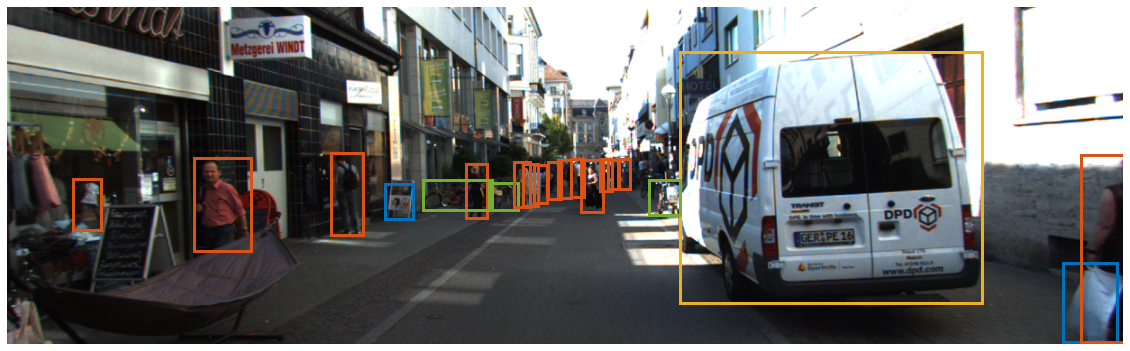

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(img)
ax = plt.gca()
for k in data.index:
    #x_range = np.arange(int(data.iloc[k,0]), int(data.iloc[k,2])+1) # xmax~xmin 
    #line_range = np.arange(500, 742+1)

    # 겹칠 때 판단하기
    if True == True: 
        classes = data.iloc[k,-2] # class info
        '''
        Z-model 적용
        '''
        #Misc, bicycle, car, person, train, truck
        if classes == 'Misc':
            array = torch.tensor([[1,0,0,0,0,0]])
        elif classes == 'bicycle':
            array = torch.tensor([[0,1,0,0,0,0]])
        elif classes == 'car':
            array = torch.tensor([[0,0,1,0,0,0]])
        elif classes == 'person':
            array = torch.tensor([[0,0,0,1,0,0]])
        elif classes == 'train':
            array = torch.tensor([[0,0,0,0,1,0]])
        elif classes == 'truck':
            array = torch.tensor([[0,0,0,0,0,1]])
        #input_data = torch.tensor([[x1,y1,x2,y2,depth_mean,depth_median, depth_max, depth_mean_trim, width, height]])
        #input_data_scaler = torch.tensor(scaler.transform(input_data)) # scaler 적용
        input_data_scaler = torch.tensor(scaler.transform(data.iloc[[k],0:10]))

        model_data = torch.cat([input_data_scaler, array], dim=1)
        dataframe = pd.DataFrame(model_data,columns=[0,1,2,3,4,5,6,7,8,9,'Misc','bicycle','car','person','train','truck'])

        # Predict
        d_test=xgb.DMatrix(data=dataframe)
        preds = z_model.predict(d_test)
        
        
        ax.add_patch(plt.Rectangle((data.iloc[k,0], data.iloc[k,1]), data.iloc[k,2] - data.iloc[k,0], data.iloc[k,3] - data.iloc[k,1],
                                       fill=False, color=[data.iloc[k,-1][0]/255,data.iloc[k,-1][1]/255,data.iloc[k,-1][2]/255], linewidth=3))
        #text = classes
        #ax.text(data.iloc[k,0], data.iloc[k,1], text+str(np.round(preds,1)), fontsize=15,
        #        bbox=dict(facecolor='yellow', alpha=0.5))
        
plt.axis('off')
plt.show()

In [15]:
len(data) # 21

21